# ANHA4 Inter-annual Runoff Estimations

This notebook was used to test the runoff file sets in ANHA4-EXH001 which helps to understand how riverine tracer sources are dumped into the ocean.

# Content
1. [**Import modules & tools**](#Import-modules-&-tools)
1. [**Spatial distribution**](#Spatial-distribution)
1. [**Get runoff on each river**](#Get-runoff-on-each-river)

#Import modules & tools

In [13]:
import sys
sys.path.insert(0, '_libs/')

In [14]:
import glob
import scipy.io
import datetime
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from NEMO_tools import reporj_NEMOgrid
from dateutil.relativedelta import relativedelta
% matplotlib inline

# Spatial distribution

In [15]:
test_obj = nc.Dataset('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/runoff/ANHA4_runoff_monthly_combined_Dai_Trenberth_Bamber_y2014.nc')
rf2014 = test_obj.variables['runoff'][:]
nav_lon = test_obj.variables['nav_lon'][:]
nav_lat = test_obj.variables['nav_lat'][:]

In [16]:
lev = np.arange(1, 11, 1)

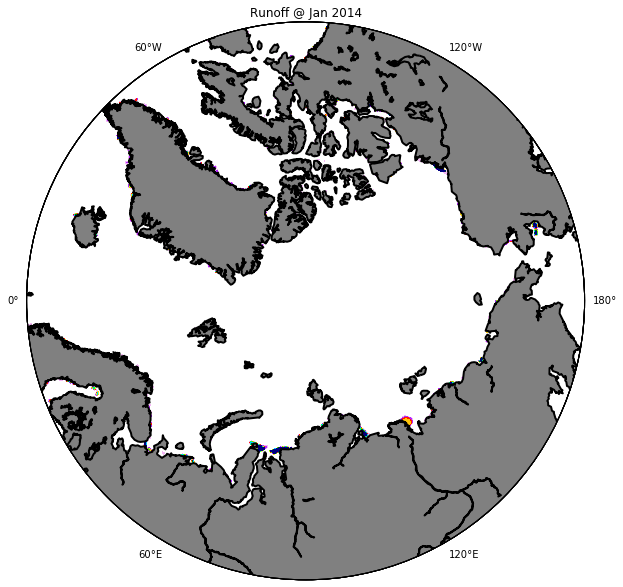

In [17]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()

proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=90, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=2.0, linestyle='-', color='k')
x, y=proj(nav_lon, nav_lat)
CS = proj.contourf(x, y, rf2014[0, :, :]*1e4, lev, cmap=plt.cm.gist_ncar_r, extend='max')
ax.set_title('Runoff @ Jan 2014')

# Get runoff on each river

In [18]:
ANHA4_MAT=scipy.io.loadmat('_data/Exchange/coord_ANHA4.mat')
ANHA4_lon=ANHA4_MAT['nav_lon']
ANHA4_lat=ANHA4_MAT['nav_lat']

In [19]:
MAT=scipy.io.loadmat('_data/Exchange/River_class.mat')
lon = MAT['lon_f']
lat = MAT['lat_f']
Class = MAT['River_class_f']

In [20]:
Class_interp = reporj_NEMOgrid(lon, lat, Class, ANHA4_lon, ANHA4_lat, method='nearest')
Class_range = reporj_NEMOgrid(lon, lat, Class, ANHA4_lon, ANHA4_lat, method='linear')
Class_interp[np.isnan(Class_range)] = np.nan

In [48]:
rf_name = glob.glob('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/runoff/*.nc')[1:]
NUM = len(rf_name)
Mackenzie = np.zeros(NUM*12)
Yukon     = np.zeros(NUM*12)
Kolyma    = np.zeros(NUM*12)
Lena      = np.zeros(NUM*12)
Yenisey   = np.zeros(NUM*12)
Ob        = np.zeros(NUM*12)
for i in range(NUM):
    nc_obj = nc.Dataset(rf_name[i])
    temp_rf = nc_obj.variables['runoff'][:]
    temp_rf[temp_rf==0]=np.nan
    for j in range(12):
        temp_rf_m = temp_rf[j, :, :]
        Mackenzie[12*i+j] = np.nanmean(temp_rf_m[Class_interp.T==7])
        Yukon[12*i+j]     = np.nanmean(temp_rf_m[Class_interp.T==8])
        Kolyma[12*i+j]    = np.nanmean(temp_rf_m[Class_interp.T==9])
        Lena[12*i+j]      = np.nanmean(temp_rf_m[Class_interp.T==12])
        Yenisey[12*i+j]   = np.nanmean(temp_rf_m[Class_interp.T==16])
        Ob[12*i+j]        = np.nanmean(temp_rf_m[Class_interp.T==17])

In [49]:
date_list = []
base = datetime.datetime(1958, 1, 1)
date_list += [base + relativedelta(months=x) for x in range(0, NUM*12, 1)]

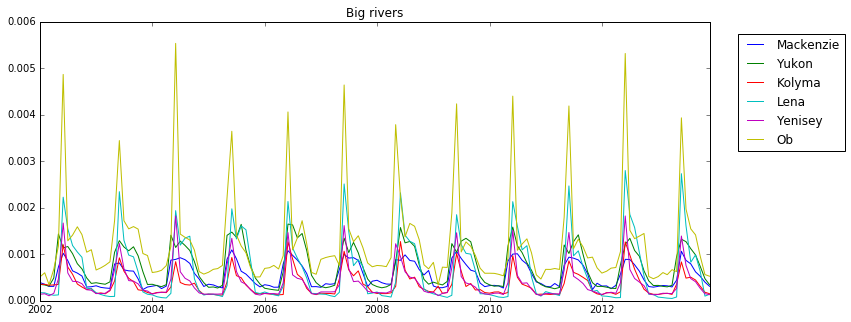

In [50]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(date_list[44*12:-12], Mackenzie[44*12:-12], label='Mackenzie')
ax.plot(date_list[44*12:-12], Yukon[44*12:-12], label='Yukon')
ax.plot(date_list[44*12:-12], Kolyma[44*12:-12], label='Kolyma')
ax.plot(date_list[44*12:-12], Lena[44*12:-12], label='Lena')
ax.plot(date_list[44*12:-12], Yenisey[44*12:-12], label='Yenisey')
ax.plot(date_list[44*12:-12], Ob[44*12:-12], label='Ob')
ax.set_title('Big rivers')
LG=ax.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=1)

In [64]:
FName = '/ocean/yingkai/GEOTRACES/Simulations/SPIN06_SET02_1m_20020101_20131231_ptrc_T.nc'

In [65]:
ptrc_obj = nc.Dataset(FName)
Ba = np.squeeze(ptrc_obj.variables['Ba'][:, 0, :, :]); Ba[Ba==0]=np.nan

In [66]:
Ba_Mackenzie = np.nanmean(Ba[:, Class_interp.T==7], 1)

In [67]:
Ba_Mackenzie.shape

(144,)

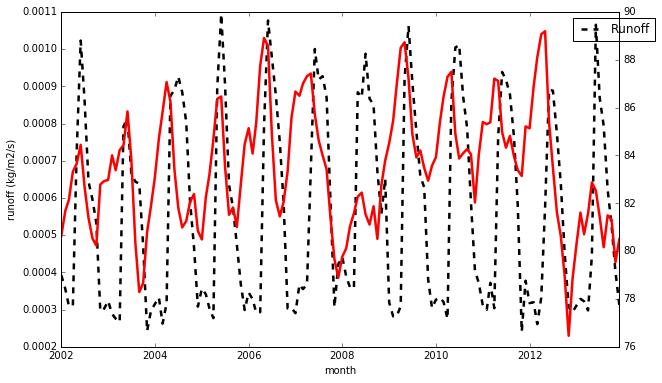

In [71]:
fig = plt.figure(figsize=(10, 6)); 
ax = fig.gca()
ax.plot(date_list[44*12:-12], Mackenzie[44*12:-12], 'k--', lw=2.5, label='Runoff')
ax.set_xlabel('month')
ax.set_ylabel('runoff (kg/m2/s)')
ax0 = ax.twinx()
ax0.plot(date_list[44*12:-12], Ba_Mackenzie, 'r-', lw=2.5, label='Barium')